# Link Prediction on Cora using a GNN Encoder–Decoder Architecture

In this notebook we implement a **link prediction model** on the Cora citation network.  
This task is fundamental for many real-world applications:

- recommender systems (user ↔ item edges),
- friend suggestions in social networks,
- protein–protein interaction prediction,
- knowledge graph completion.

### Why link prediction?

Node classification (previous notebooks) predicts **node labels**,  
but link prediction predicts **whether an edge should exist** between two nodes:

\[
u, v \rightarrow \text{should an edge connect them?}
\]

This moves us closer to our real project:  
a **GraphSAGE-based recommender system**, which is essentially link prediction on a user–item graph.

## Model Architecture

We use a classic encoder–decoder framework:

### **1) Encoder (GNN)**
A 2-layer GCN that produces node embeddings:

\[
h = \text{GNN}(X, A)
\]

### **2) Decoder**
We reconstruct edges using a dot-product scoring function:

\[
\hat{y}_{uv} = \sigma(h_u^\top h_v)
\]

### **3) Negative Sampling**
True edges (positive pairs) come from the graph.  
False edges (negative pairs) are sampled at each epoch.

## What this notebook will do

✔ Load Cora and split edges into train / val / test  
✔ Train a GNN encoder to perform link prediction  
✔ Evaluate with **ROC-AUC** and **Average Precision (AP)**  
✔ Save model, embeddings, and edge scores in `artifacts/cora_linkpred`  

This notebook marks the transition from **node-level tasks** to **edge-level tasks**,  
which is essential for building a graph-based recommender system.

In [1]:
import os
from pathlib import Path

import torch
import torch.nn.functional as F
from torch.nn import Module, Linear
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.nn import GCNConv

from torch_geometric.utils import train_test_split_edges, negative_sampling
from torch_geometric.utils import to_undirected

from sklearn.metrics import roc_auc_score, average_precision_score
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import umap
from sklearn.preprocessing import StandardScaler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [2]:
PROJECT_ROOT = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
DATA_ROOT = PROJECT_ROOT / "data" / "Planetoid"
DATA_ROOT.mkdir(parents=True, exist_ok=True)

dataset = Planetoid(
    root=str(DATA_ROOT),
    name="Cora",
    transform=NormalizeFeatures()
)
data = dataset[0]

# Important: turn edges into undirected graph
data.edge_index = to_undirected(data.edge_index)

# Create train/val/test splits for edges
data = train_test_split_edges(data)
data = data.to(device)

print("Dataset ready for link prediction")
print(data)

C:\Users\555\AppData\Local\Temp\ipykernel_21460\1350960908.py:16: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  data = train_test_split_edges(data)


Dataset ready for link prediction
Data(x=[2708, 1433], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708], val_pos_edge_index=[2, 263], test_pos_edge_index=[2, 527], train_pos_edge_index=[2, 8976], train_neg_adj_mask=[2708, 2708], val_neg_edge_index=[2, 263], test_neg_edge_index=[2, 527])


In [3]:
class GCNEncoder(Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x  # embeddings


def decode(z, edge_index):
    # dot product decoder
    src, dst = edge_index
    return (z[src] * z[dst]).sum(dim=1)


def decode_sigmoid(z, edge_index):
    return torch.sigmoid(decode(z, edge_index))

In [4]:
model = GCNEncoder(
    in_channels=dataset.num_features,
    hidden_channels=64,
    out_channels=32,
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [5]:
@torch.no_grad()
def evaluate(z, pos_edge_index, neg_edge_index):
    pos_pred = decode_sigmoid(z, pos_edge_index).cpu().numpy()
    neg_pred = decode_sigmoid(z, neg_edge_index).cpu().numpy()

    y_true = [1] * len(pos_pred) + [0] * len(neg_pred)
    y_pred = list(pos_pred) + list(neg_pred)

    auc = roc_auc_score(y_true, y_pred)
    ap = average_precision_score(y_true, y_pred)
    return auc, ap

In [6]:
best_auc = 0
ART_ROOT = PROJECT_ROOT / "artifacts" / "cora_linkpred"
ART_ROOT.mkdir(parents=True, exist_ok=True)

for epoch in tqdm(range(1, 201)):

    model.train()
    optimizer.zero_grad()

    # Compute embeddings on training edges only
    z = model(data.x, data.train_pos_edge_index)

    # Positive edges
    pos_pred = decode_sigmoid(z, data.train_pos_edge_index)

    # Negative edges (sampled each epoch)
    neg_edge_index = negative_sampling(
        edge_index=data.train_pos_edge_index,
        num_nodes=data.num_nodes,
        num_neg_samples=data.train_pos_edge_index.size(1),
    )
    neg_pred = decode_sigmoid(z, neg_edge_index)

    # Loss
    pos_loss = -torch.log(pos_pred + 1e-15).mean()
    neg_loss = -torch.log(1 - neg_pred + 1e-15).mean()
    loss = pos_loss + neg_loss

    loss.backward()
    optimizer.step()

    # Validation
    model.eval()
    z = model(data.x, data.train_pos_edge_index)
    val_auc, val_ap = evaluate(
        z, data.val_pos_edge_index, data.val_neg_edge_index
    )

    if val_auc > best_auc:
        best_auc = val_auc
        torch.save(model.state_dict(), ART_ROOT / "model_linkpred_best.pt")

    if epoch % 10 == 0:
        print(
            f"Epoch {epoch:03d} | loss={loss:.4f} | val_auc={val_auc:.4f} | val_ap={val_ap:.4f}"
        )

  8%|▊         | 15/200 [00:01<00:08, 22.10it/s]

Epoch 010 | loss=1.3338 | val_auc=0.6603 | val_ap=0.7150


 12%|█▎        | 25/200 [00:01<00:05, 32.18it/s]

Epoch 020 | loss=1.2162 | val_auc=0.7905 | val_ap=0.8053


 18%|█▊        | 35/200 [00:01<00:04, 36.96it/s]

Epoch 030 | loss=1.0786 | val_auc=0.8330 | val_ap=0.8435


 22%|██▎       | 45/200 [00:01<00:03, 38.88it/s]

Epoch 040 | loss=1.0031 | val_auc=0.8731 | val_ap=0.8848


 28%|██▊       | 55/200 [00:01<00:03, 40.21it/s]

Epoch 050 | loss=0.9554 | val_auc=0.8985 | val_ap=0.9043


 32%|███▎      | 65/200 [00:02<00:03, 40.88it/s]

Epoch 060 | loss=0.9189 | val_auc=0.9026 | val_ap=0.9130


 38%|███▊      | 75/200 [00:02<00:03, 39.22it/s]

Epoch 070 | loss=0.9062 | val_auc=0.9089 | val_ap=0.9156


 42%|████▎     | 85/200 [00:02<00:02, 39.37it/s]

Epoch 080 | loss=0.8983 | val_auc=0.9087 | val_ap=0.9179


 48%|████▊     | 95/200 [00:02<00:02, 39.54it/s]

Epoch 090 | loss=0.8976 | val_auc=0.9101 | val_ap=0.9212


 52%|█████▎    | 105/200 [00:03<00:02, 41.43it/s]

Epoch 100 | loss=0.8973 | val_auc=0.9082 | val_ap=0.9191


 57%|█████▊    | 115/200 [00:03<00:02, 40.05it/s]

Epoch 110 | loss=0.8883 | val_auc=0.9063 | val_ap=0.9172


 62%|██████▎   | 125/200 [00:03<00:01, 40.68it/s]

Epoch 120 | loss=0.8870 | val_auc=0.9089 | val_ap=0.9192


 68%|██████▊   | 135/200 [00:03<00:01, 42.56it/s]

Epoch 130 | loss=0.8824 | val_auc=0.9079 | val_ap=0.9197


 72%|███████▎  | 145/200 [00:04<00:01, 44.53it/s]

Epoch 140 | loss=0.8795 | val_auc=0.9066 | val_ap=0.9186
Epoch 150 | loss=0.8699 | val_auc=0.9084 | val_ap=0.9196


 82%|████████▎ | 165/200 [00:04<00:00, 45.05it/s]

Epoch 160 | loss=0.8714 | val_auc=0.9102 | val_ap=0.9209


 88%|████████▊ | 175/200 [00:04<00:00, 43.84it/s]

Epoch 170 | loss=0.8613 | val_auc=0.9145 | val_ap=0.9246


 92%|█████████▎| 185/200 [00:05<00:00, 44.71it/s]

Epoch 180 | loss=0.8538 | val_auc=0.9160 | val_ap=0.9272


 98%|█████████▊| 195/200 [00:05<00:00, 45.36it/s]

Epoch 190 | loss=0.8422 | val_auc=0.9143 | val_ap=0.9258


100%|██████████| 200/200 [00:05<00:00, 37.20it/s]

Epoch 200 | loss=0.8450 | val_auc=0.9139 | val_ap=0.9258


In [7]:
model.load_state_dict(torch.load(ART_ROOT / "model_linkpred_best.pt"))
model.eval()

z = model(data.x, data.train_pos_edge_index)

test_auc, test_ap = evaluate(
    z,
    data.test_pos_edge_index,
    data.test_neg_edge_index,
)

print("Best validation AUC:", best_auc)
print("Test AUC:", test_auc)
print("Test AP :", test_ap)

torch.save(z.cpu(), ART_ROOT / "embeddings.pt")

Best validation AUC: 0.917434110656508
Test AUC: 0.9070604798202565
Test AP : 0.9020037953011747


C:\Users\555\AppData\Local\Temp\ipykernel_21460\3183112530.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ART_ROOT / "model_linkpred_be

Embeddings shape: (2708, 32)
Labels shape: (2708,)


D:\Anaconda\envs\gnn_clean\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP 2D shape: (2708, 2)


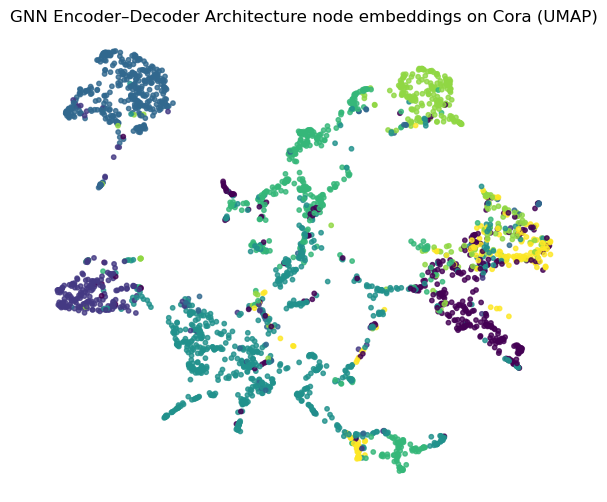

In [10]:
@torch.no_grad()
def get_node_embeddings(model, data):
    model.eval()
    # используем обучающий граф для извлечения эмбеддингов
    z = model(data.x, data.train_pos_edge_index)
    return z.cpu().numpy(), data.y.cpu().numpy()

emb, labels = get_node_embeddings(model, data)
print("Embeddings shape:", emb.shape)
print("Labels shape:", labels.shape)

# стандартизируем перед UMAP
emb_scaled = StandardScaler().fit_transform(emb)

reducer = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    n_components=2,
    metric="euclidean",
    random_state=42,
)
emb_2d = reducer.fit_transform(emb_scaled)
print("UMAP 2D shape:", emb_2d.shape)

plt.figure(figsize=(7, 6))
scatter = plt.scatter(
    emb_2d[:, 0],
    emb_2d[:, 1],
    c=labels,
    s=10,
    alpha=0.8,
)
plt.title("GNN Encoder–Decoder Architecture node embeddings on Cora (UMAP)")
plt.axis("off")
plt.show()

## Conclusion

In this notebook we implemented **link prediction** on the Cora citation network using a simple GNN encoder–decoder architecture:

- **Encoder:** 2-layer GCN that produces node embeddings  
- **Decoder:** dot-product scoring function with sigmoid to estimate the probability of an edge

We used `train_test_split_edges` to create train/validation/test splits over edges and trained the model with positive and negative sampling.

### Performance

- **Best validation AUC:** ≈ 0.917  
- **Test AUC:** ≈ 0.907  
- **Test Average Precision (AP):** ≈ 0.902  

These numbers indicate that the model:

- clearly separates **existing edges** from **non-edges** in embedding space,
- learns a meaningful representation of the citation graph,
- can be used as a strong baseline for edge-level tasks.

### What we achieved

✔ Switched from node classification to **edge prediction**  
✔ Implemented a classic **GNN encoder + dot-product decoder** setup  
✔ Used **negative sampling** to construct a balanced training objective  
✔ Evaluated the model with robust metrics (ROC-AUC, Average Precision)  
✔ Saved trained embeddings and model weights to `artifacts/cora_linkpred`  

This notebook is a key milestone: it shows how GNNs can be used not only to classify nodes, but also to **predict new links** — the core idea behind many real-world systems:

- recommender systems (user–item edges),
- friend suggestions,
- interaction prediction in biological or financial graphs.

### Next steps

With a working link prediction baseline in place, we are ready to move towards more realistic settings:

1. **GraphSAGE with neighbor sampling** on larger graphs  
2. **Graph-based recommender system**, where:
   - nodes represent users and items,
   - edges represent interactions (ratings, clicks, purchases),
   - link prediction becomes “recommend the next likely connection”.

This will bridge the gap between small academic benchmarks (lik Cora) and real-world graph ML applications.
